In [1]:
import adi
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy as sp
import sdr_utils as sutil
import seaborn as sns
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objects as go
from numpy.fft import fft, ifft

In [2]:
#sdr = adi.ad9361(uri='ip:192.168.2.1')
samp_rate = 30.72e6    # must be <=30.72 MHz if both channels are enabled
num_samps_tx = 2**18
#num_samps_rx = 2**21
num_samps_rx = 2**21
#num_samps = 2**18      # number of samples per buffer.  Can be different for Rx and Tx
rx_lo = 2.4e9
rx_mode = "manual"  # can be "manual" or "slow_attack"
rx_gain0 = 50
rx_gain1 = 50
tx_lo = rx_lo
tx_gain0 = -40
tx_gain1 = -40 # make -89 when RF coupling

In [3]:
'''Configure Rx properties'''
sdr.rx_enabled_channels = [0, 1]
sdr.sample_rate = int(samp_rate)
sdr.rx_lo = int(rx_lo)
sdr.gain_control_mode_chan0 = rx_mode
sdr.gain_control_mode_chan1 = rx_mode

sdr.rx_hardwaregain_chan0 = int(rx_gain0)
sdr.rx_hardwaregain_chan1 = int(rx_gain1)
sdr.rx_buffer_size = int(num_samps_rx)

'''Configure Tx properties'''
sdr.tx_rf_bandwidth = int(samp_rate)
sdr.tx_lo = int(tx_lo)
sdr.tx_cyclic_buffer = True
sdr.tx_hardwaregain_chan0 = int(tx_gain0)
sdr.tx_hardwaregain_chan1 = int(tx_gain1)
sdr.tx_buffer_size = int(num_samps_tx)

### NanoVNA analysis of TX Antenna (Chicory)
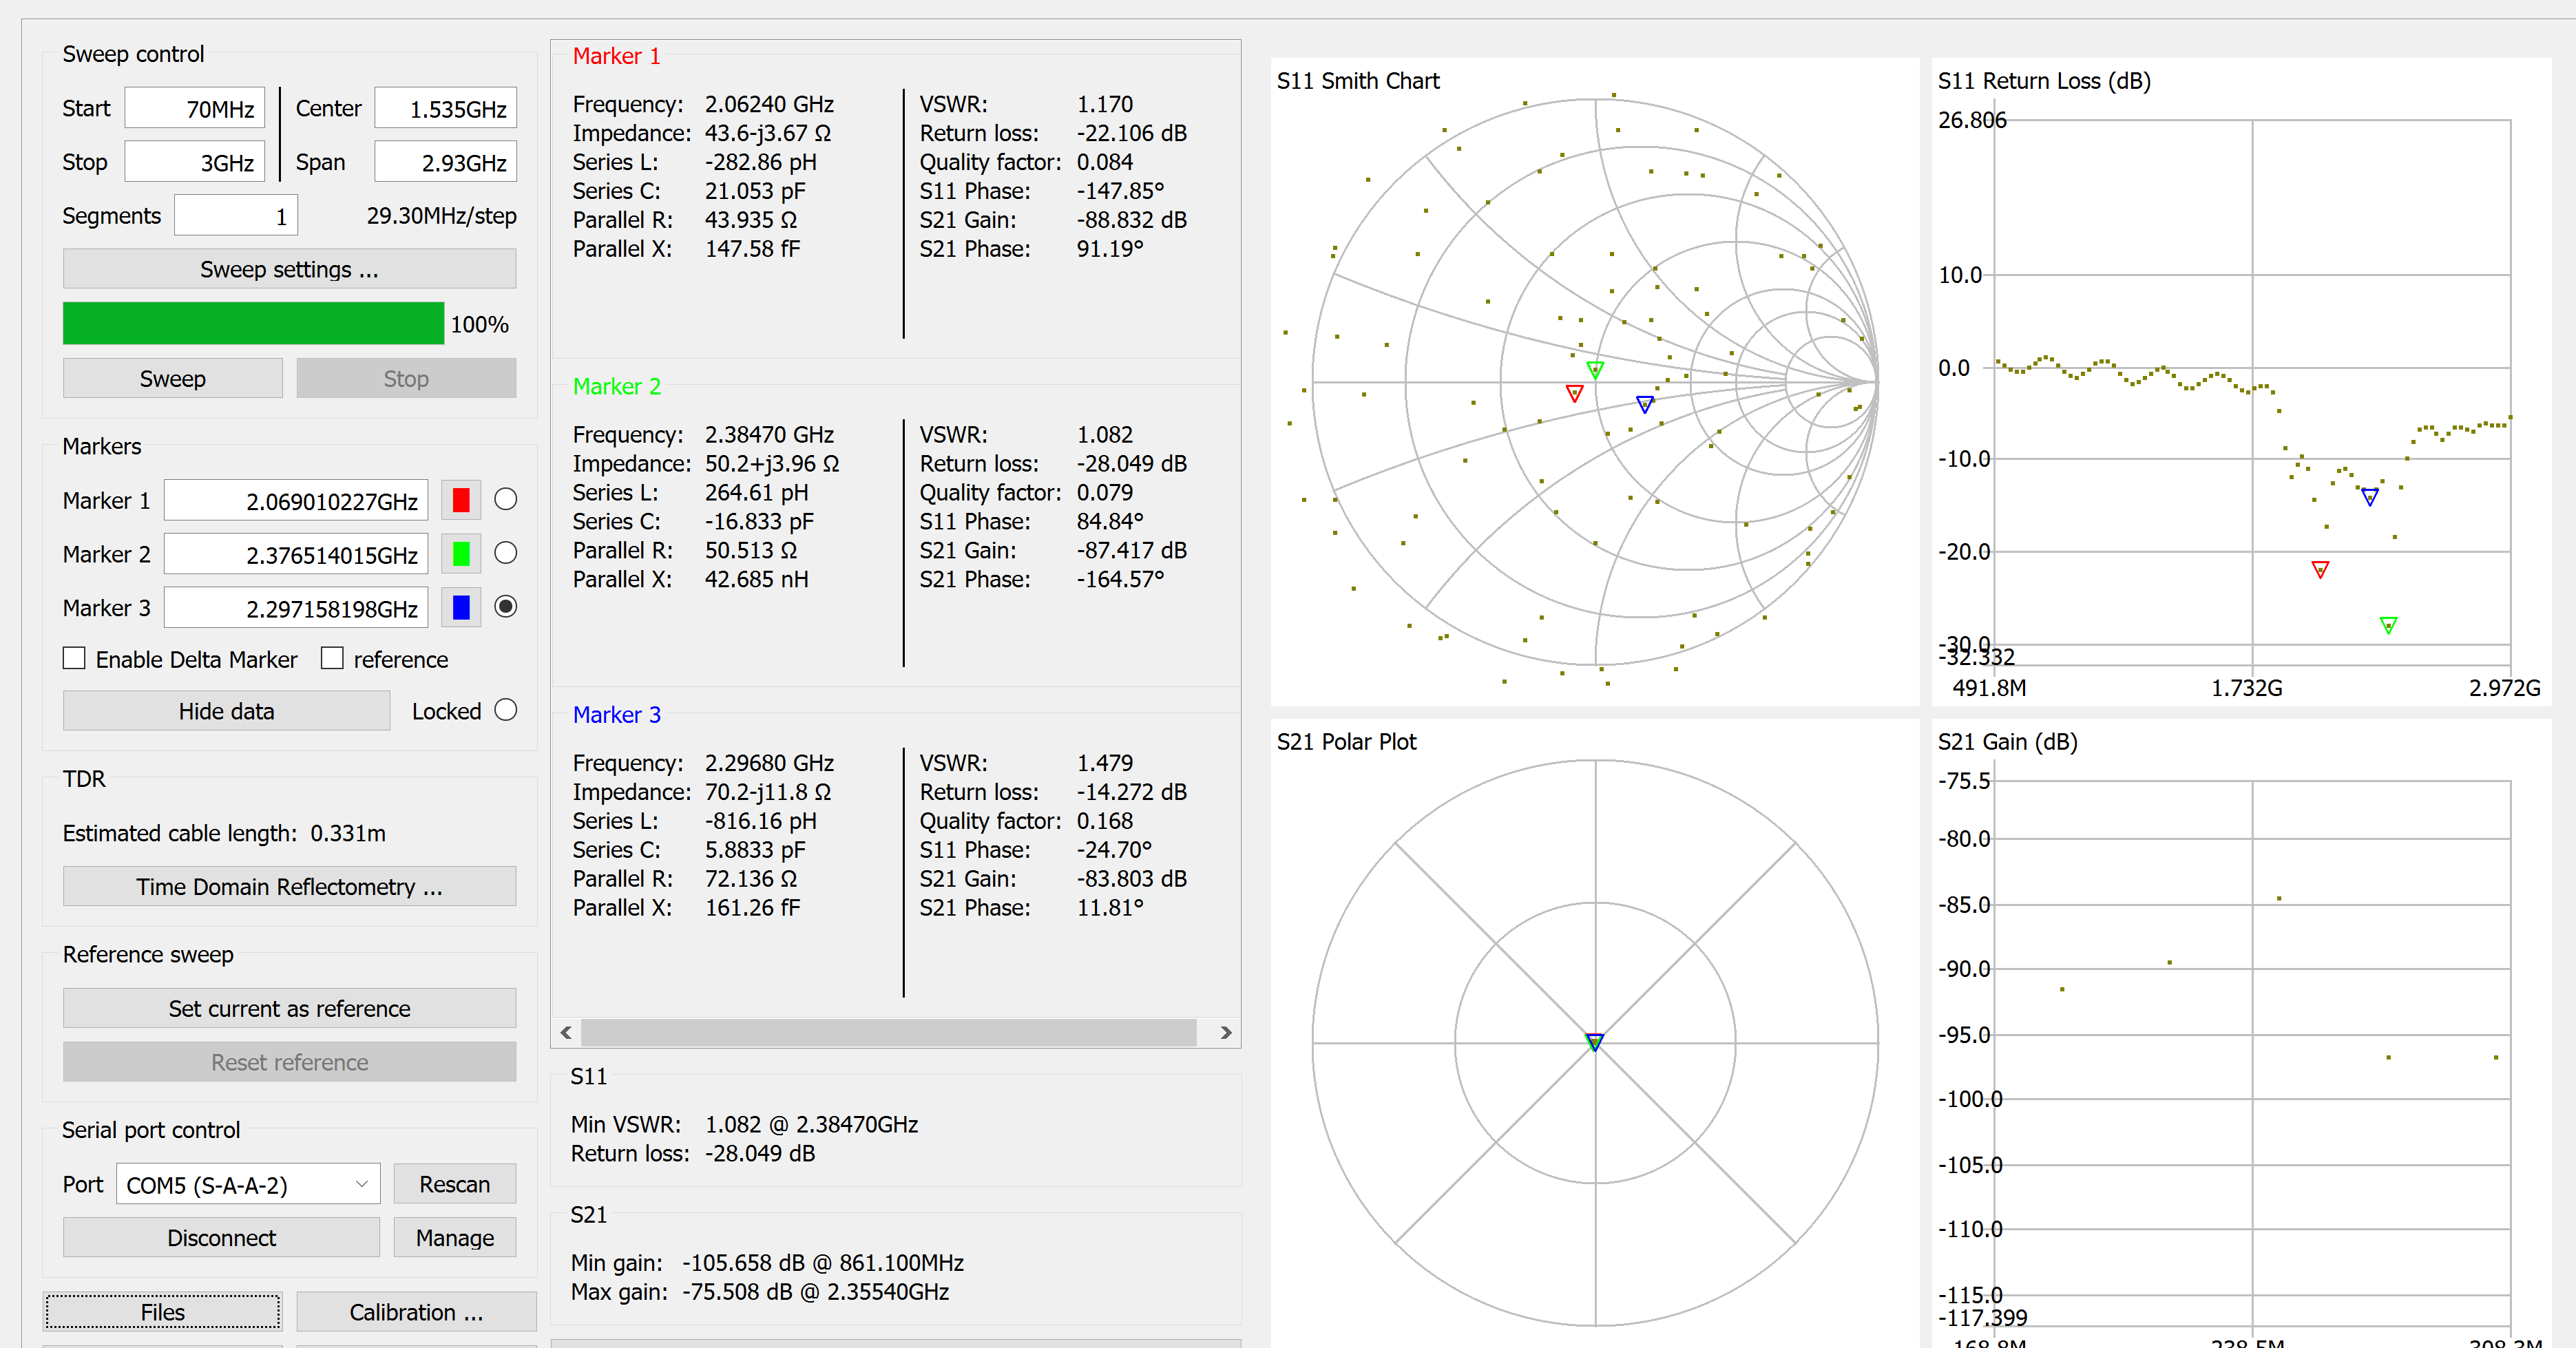

### NanoVNA analysis of RX Antenna (French)
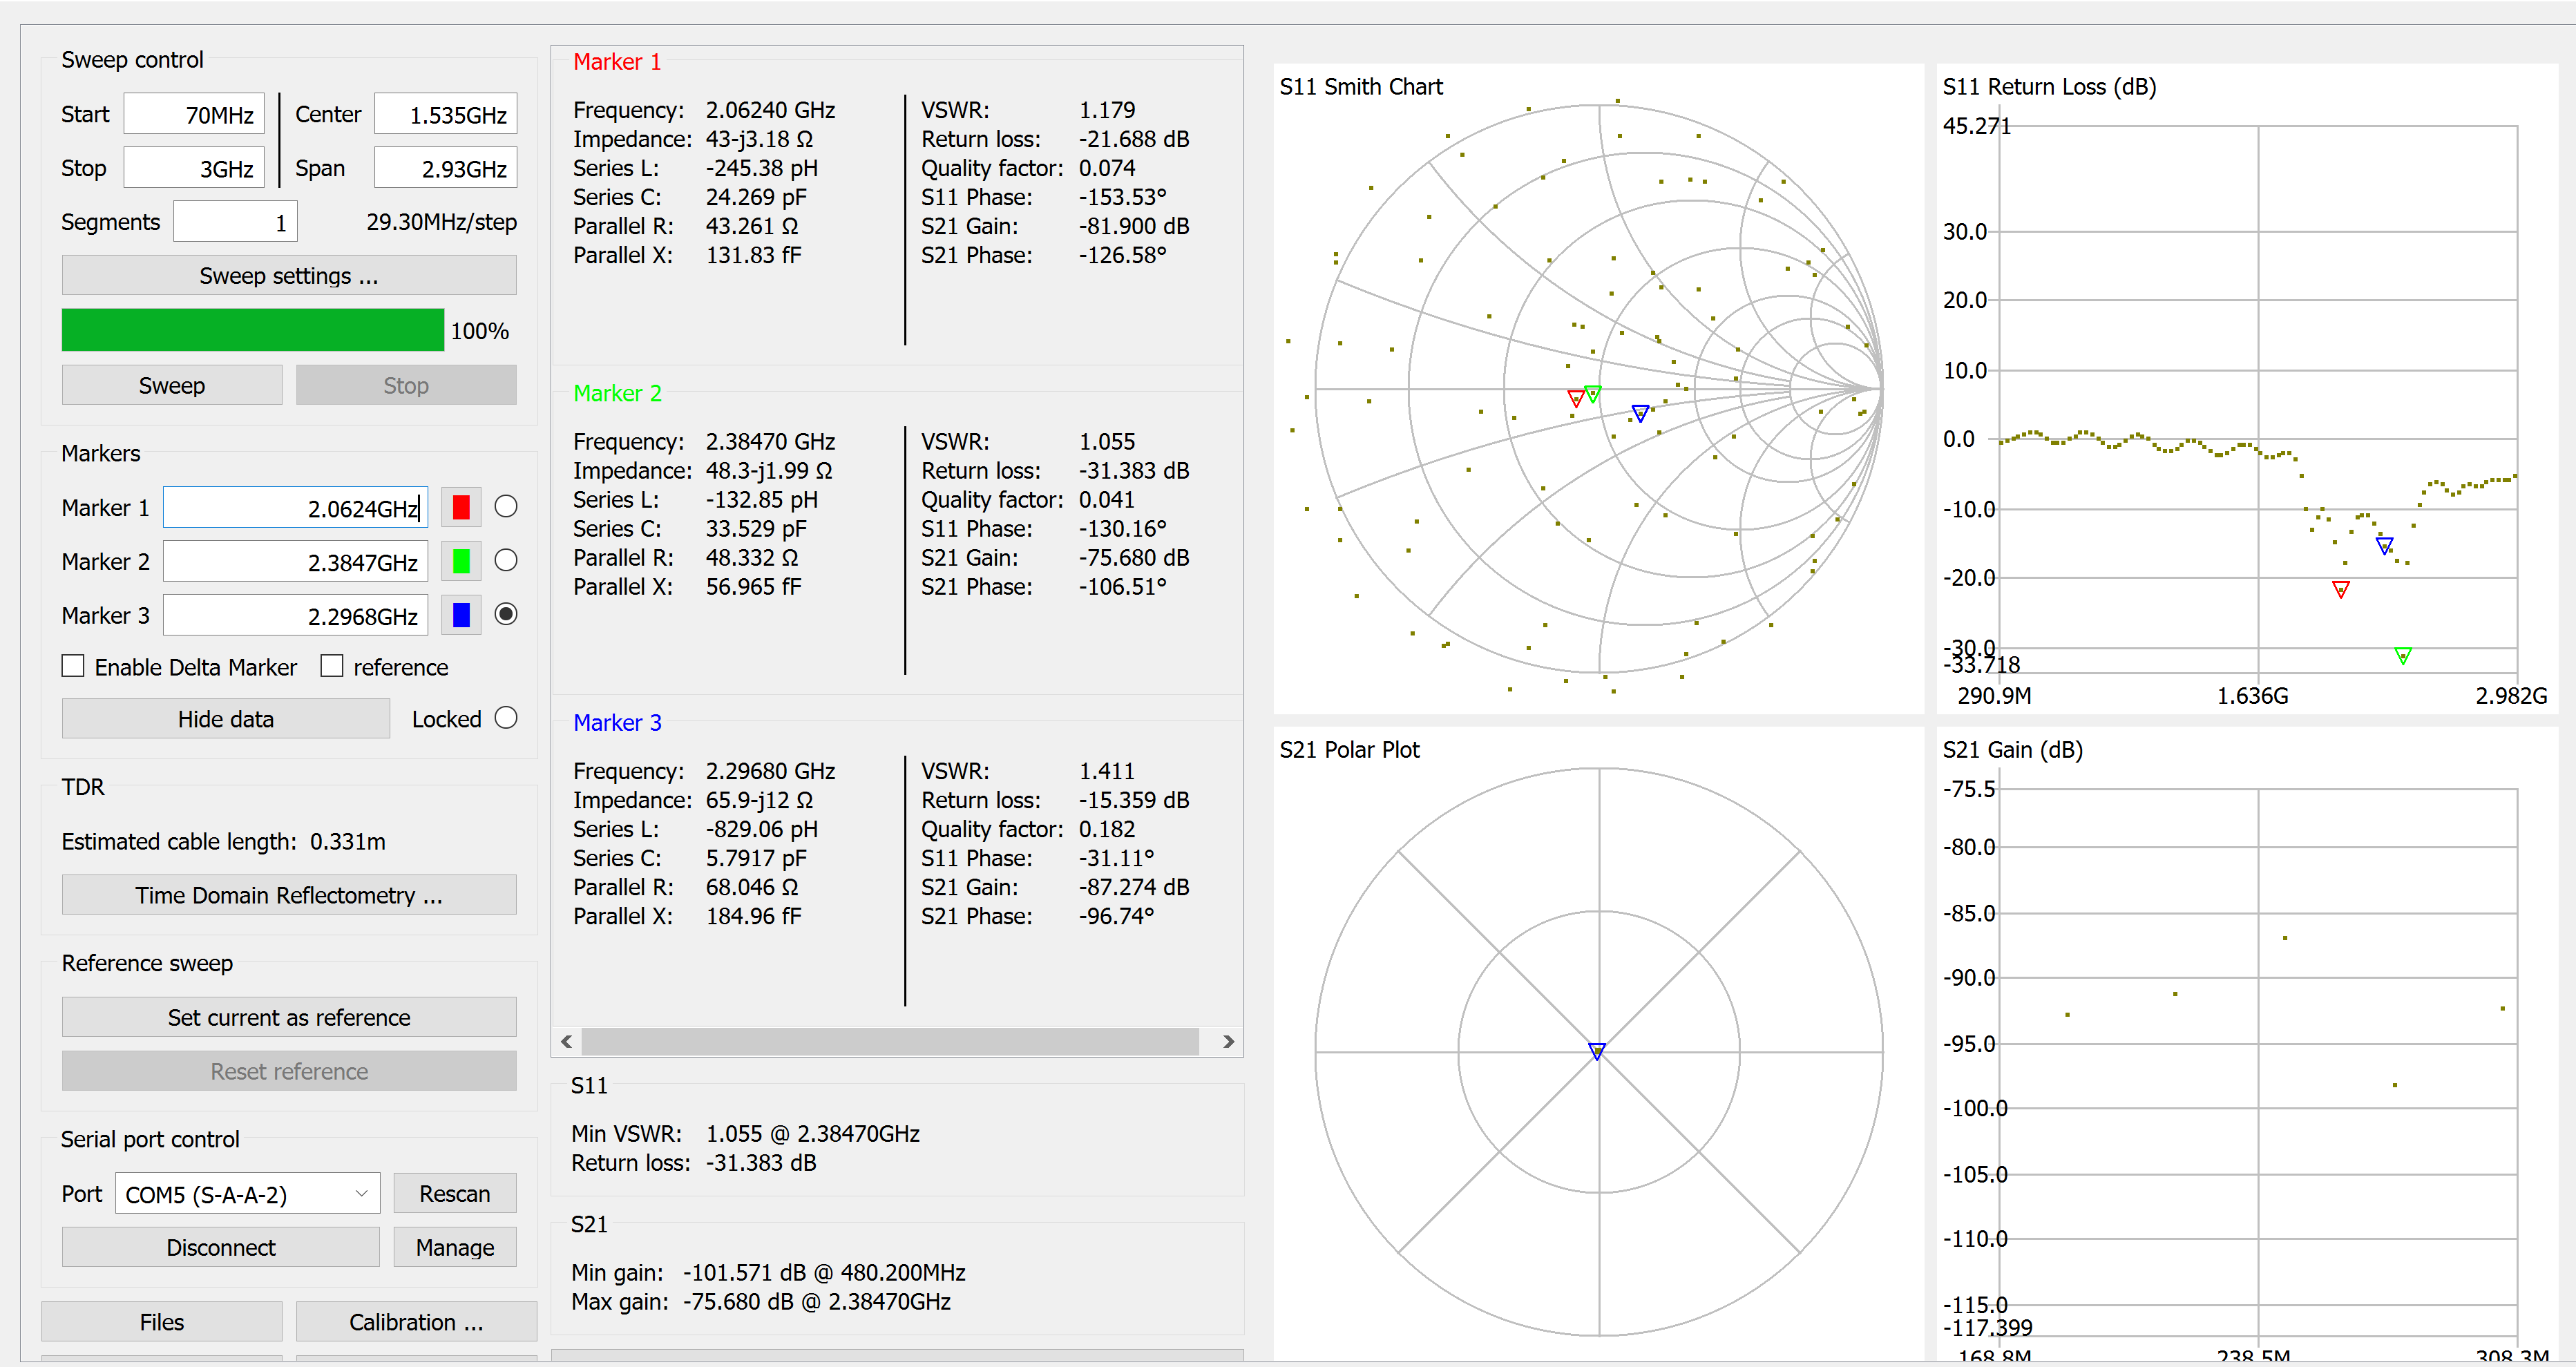

From the VNA sweeps above, marker 2 (green) is identifying the frequency around 2.4 GHz which corresponds to the strongest radiation (lowest reflected energy). It appears that the RX antenna (-31.383 dB) is slightly better than the TX antenna (-28.049 dB). Although the VNA was calibrated correctly prior to measurements, the VNA is a hobby grade analyzer and will likely be within 0.5 dB of true.

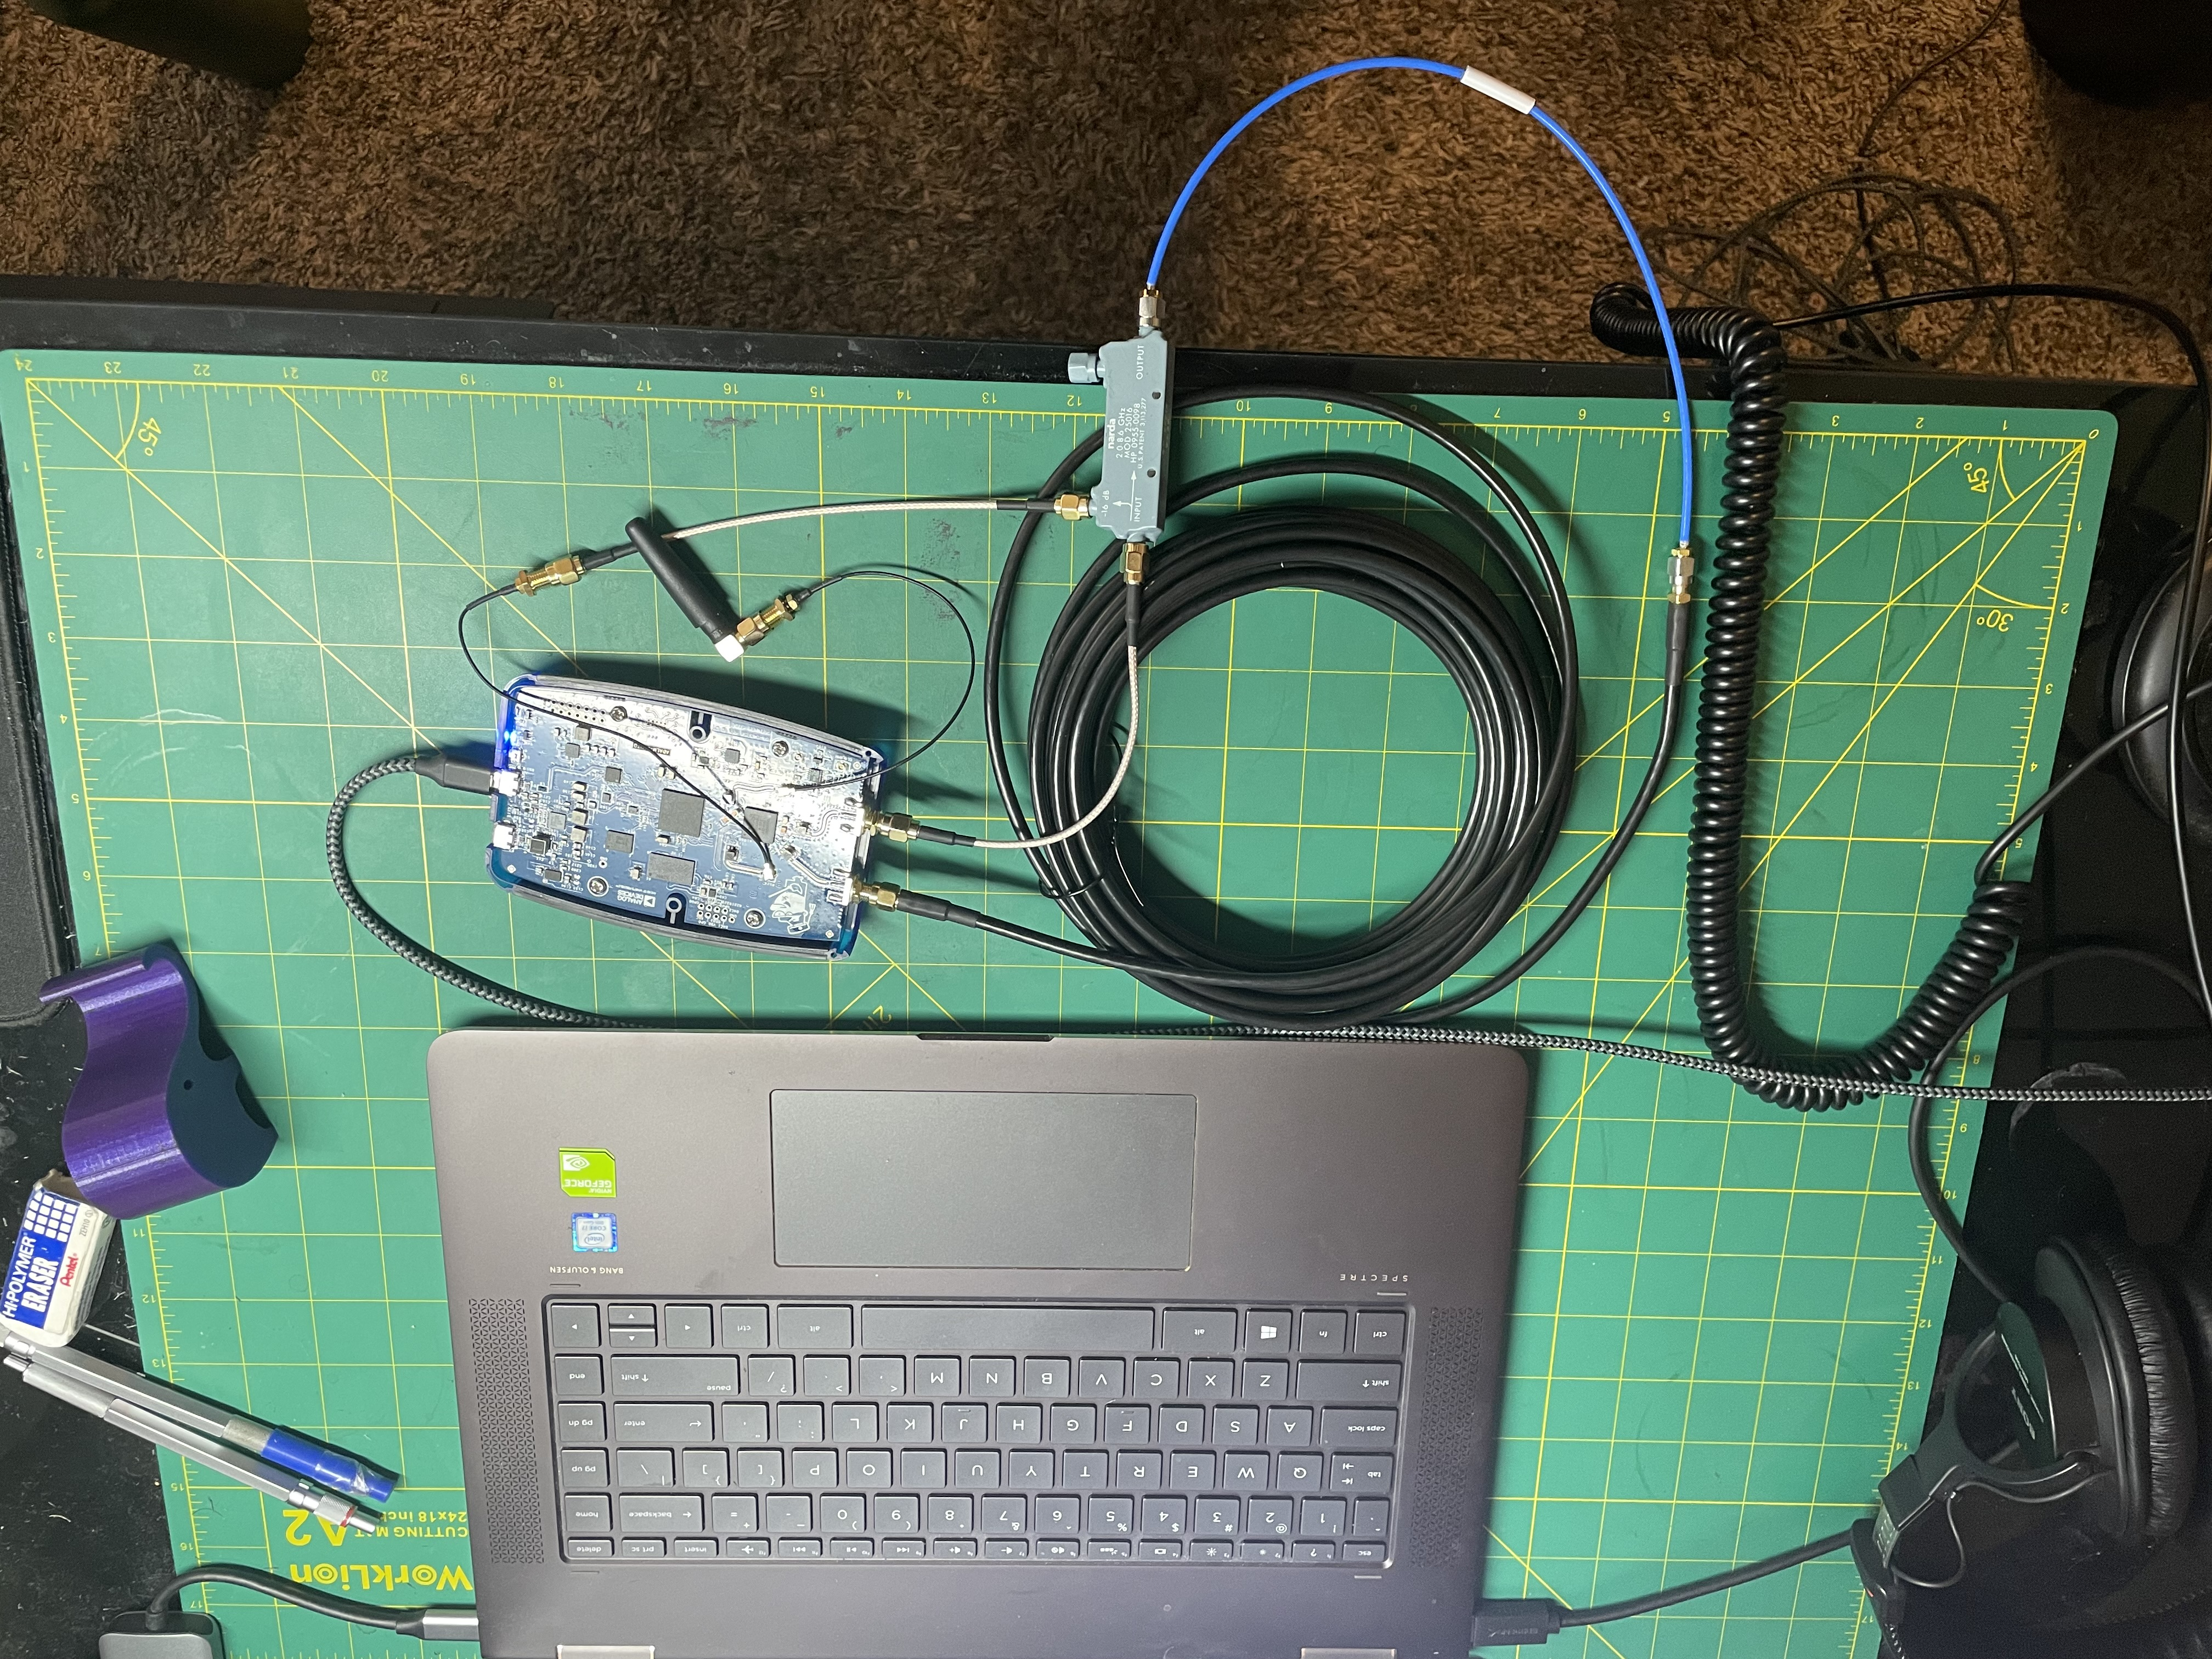

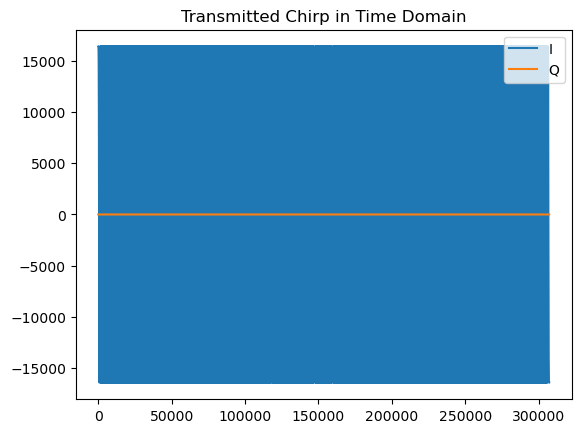

In [10]:
BW = samp_rate / 2 # nyquist
BW = BW/2
BW = 8e6
f_low = 300
f_high = BW - f_low
chirp_duration = 5e-3
dfdt = (f_high - f_low) / chirp_duration
Ts = 1/samp_rate
#BW = 2e6 # Hz
# trying to generate a chirp 
t_range = np.arange(0, chirp_duration, Ts)
FM_chirp = signal.chirp(t_range, f_low, chirp_duration, f_high, method = 'linear')

# plt.plot(t_range, FM_chirp)
# plt.show()
#plot_spectrogram("title", FM_chirp, num_samps)

# print(len(FM_chirp))

tx_chirp = FM_chirp * 2**14
#shaped = sutil.raised_cos_filter(tx_chirp, β = 0.9)
shaped = tx_chirp
fm_down_chirp = np.flip(shaped)
shaped = np.concatenate([shaped,-1*fm_down_chirp])
I = shaped
Q = np.zeros(len(shaped))
IQ_send = Q + 1j*Q
IQ2 = I + 1j*Q
#IQ_send = np.concatenate([IQ_send, IQ_send, IQ_send, IQ_send, IQ_send, IQ2, IQ2])
IQ_send = IQ2

TX2_zeros = np.zeros(len(IQ_send))
TX2_zeros = IQ_send

# plt.plot(shaped)
# plt.show()
# print(len(shaped))

plt.title("Transmitted Chirp in Time Domain")
plt.plot(IQ_send.real)
plt.plot(IQ_send.imag)
plt.legend(["I", "Q"])
plt.show()

(0.0, 10000000.0)

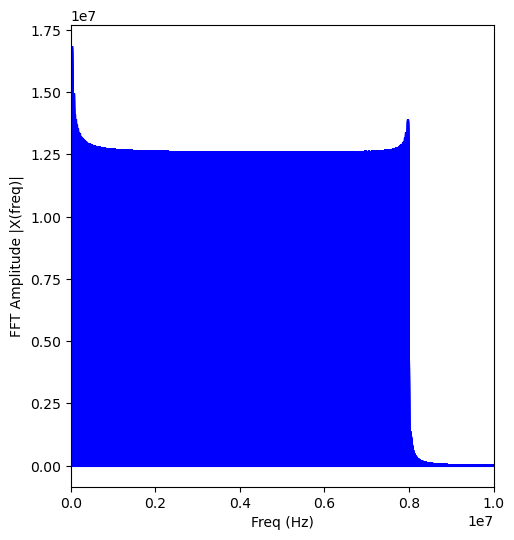

In [11]:
from numpy.fft import fft, ifft
sr = samp_rate
x = IQ_send

X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10e6)

#### Chirp Generation

In the above code, an upchirp is generated over a specified pulse duration followed by a reversal of the upchirp to create a downchirp. This allows the radar to distinguish between doppler frequency shifts and range frequency shifts.

$$
f_{low} = 300\ Hz\\
f_{high} = 3000\ Hz\\
t_{chirp} = \Delta T = 8\ ms \\
\Delta f = f_{high} - f_{low} = 2700 \ Hz\\
\frac{df}{dt} = \frac{\Delta f}{\Delta T} = \frac{2700\ Hz}{8\ ms} = 337.5\ \frac{kHz}{s}
$$

The distance to the reflected object is computed as follows:

$$
R = \frac{c_0 |\Delta t|}{2} = \frac{c_0 \Delta f}{2 \cdot \frac{df}{dt}} \\
R = \frac{3e8 \cdot |\Delta f|}{2 \cdot 337.5e3 \ Hz} = 444.44 \cdot \Delta f
$$

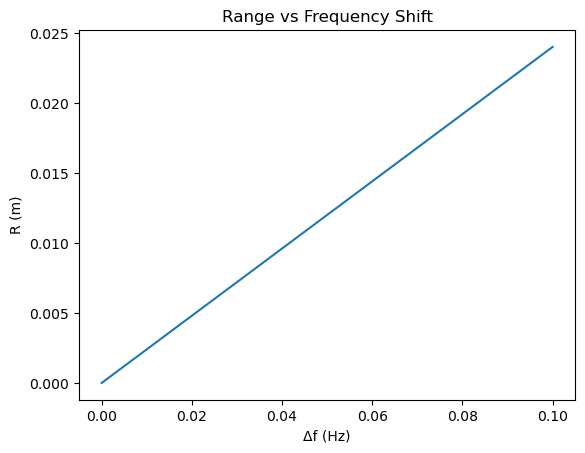

In [13]:
# plotting the range versus the frequency shift of the mixed signals
Δf = np.linspace(0, 0.1, 1000)
df_dt = (f_high - f_low)/chirp_duration
R = (3e8 * Δf)/(2*df_dt)
plt.plot(Δf, R)
plt.title("Range vs Frequency Shift")
plt.xlabel("Δf (Hz)")
plt.ylabel("R (m)")
plt.show()

From the plot above, we can see that very low beat frequencies (less than 0.1 Hz) correspond to the short range detectons. The short range performace can be improved by increasing $\frac{df}{dt}$ but that is limited by the bandwidth of the Pluto SDR. With a sample rate $fs = 30.72\ MHz$, then from the Nyquist sampling criterion, the maximum frequency that can be in the transmit signal is $\frac{fs}{2} = 15.36\ MHz$ which would be our bandwidth limit. Additionally, the Pluto SDR appears to have uneven attenuation when transmitting the chirp.

In [23]:
# Start the transmitter
#sdr.tx_cyclic_buffer = False # Enable cyclic buffers
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx([IQ_send, TX2_zeros]) # start transmitting

#sdr.rx_annotated = False
for i in range(0,10):
   sdr.rx()

sample_rx = sdr.rx()
data_rx_0 = sample_rx[0]
data_rx_1 = sample_rx[1]
    
    
sdr.tx_destroy_buffer()

t_f = 0.06826666666666667


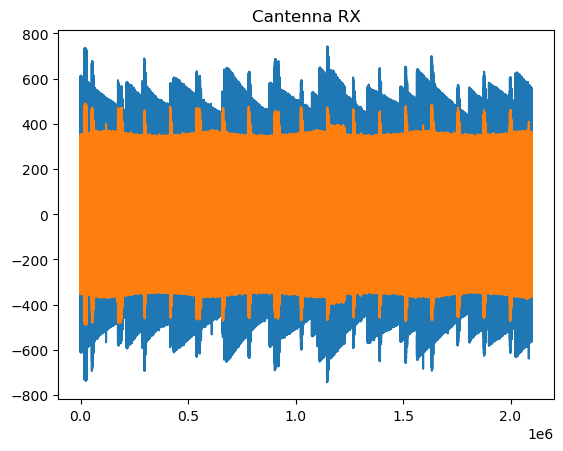

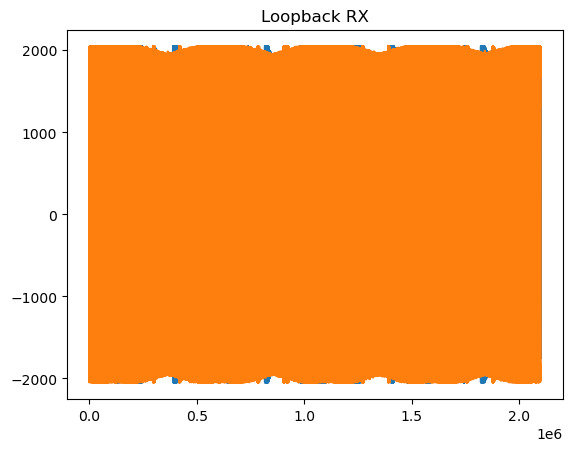

In [24]:
t_i = 0.0
t_f = num_samps_rx * (1/sdr.sample_rate)
t = np.linspace(t_i, t_f, num=len(data_rx_0.real)) * 1e3
print(f"t_f = {t_f}")

plt.plot(data_rx_0.real)
plt.plot(data_rx_0.imag)
plt.title("Cantenna RX")
plt.show()

# [0:len(IQ_send)]
plt.plot(data_rx_1.real)
plt.plot(data_rx_1.imag)
plt.title("Loopback RX")
plt.show()



The received signals have a significant amount of high frequency noise introduced so an FIR filter is used to remove the high frequency components of the signal. The plots below show a single chirp duration showing the upchirp and downchirp. The filter may be too aggressive as it stands because the high frequency parts of the chirp are significantly attenuated compared to the lower frequencies.

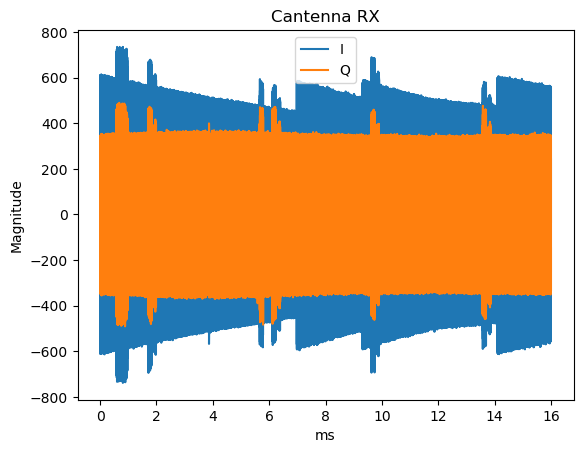

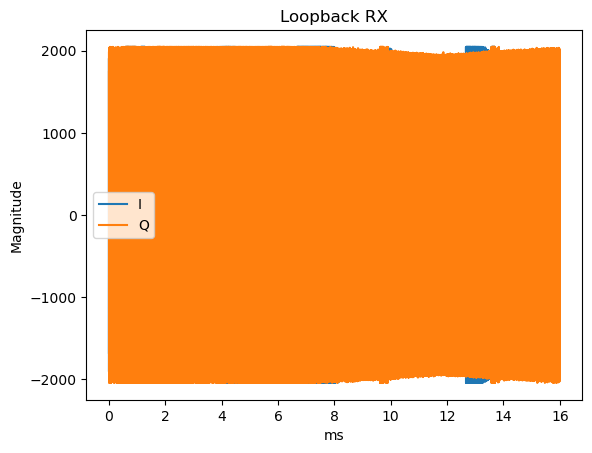

In [25]:
num_taps = 10001 # it helps to use an odd number of taps
cut_off = BW # Hz
sample_rate = sdr.sample_rate # Hz
h = signal.firwin(num_taps, cut_off, nyq=sample_rate/2)
#data_rx_0_h = np.convolve(data_rx_0, h)
#data_rx_1_h = np.convolve(data_rx_1, h)

data_rx_0_h = data_rx_0
data_rx_1_h = data_rx_1
t = np.linspace(0, chirp_duration*2, len(IQ_send))

plt.plot(t * 1e3, data_rx_0_h.real[0:len(IQ_send)])
plt.plot(t * 1e3, data_rx_0_h.imag[0:len(IQ_send)])
plt.xlabel("ms")
plt.ylabel("Magnitude")
plt.legend(["I", "Q"])
plt.title("Cantenna RX")
plt.show()

# [0:len(IQ_send)]
plt.plot(t * 1e3, data_rx_1_h.real[0:len(IQ_send)])
plt.plot(t * 1e3, data_rx_1_h.imag[0:len(IQ_send)])
plt.xlabel("ms")
plt.ylabel("Magnitude")
plt.legend(["I", "Q"])
plt.title("Loopback RX")
plt.show()

Digital mixing is performed in the IQ domain by multiplying the cantenna rx signal, $S_{rx}$, with the complex conjugate of the loopback signal, $S_{loopback}$.

$$
S_{mixed} = S_{rx} \cdot conj(S_{loopback})
$$

The mixed signal is additionally filtered with an FIR filter to isolate the beat frequency. The beat frequency of the mixed signal corresponds with the frequency shift $\Delta f$ caused by the target range.

In [26]:
# mixing and filtering:
mixed = data_rx_0_h * np.conjugate(data_rx_1_h)
q = 20
#mixed_decimated = signal.decimate(mixed, q)
num_taps = 100001 # it helps to use an odd number of taps
#num_taps = 10001
cut_off = 500 # Hz
sample_rate = sdr.sample_rate # Hz
h = signal.firwin(num_taps, cut_off, nyq=sample_rate/2)
#mixed_h = np.convolve(mixed, h)
mixed_h = mixed


#mixed_decimated_h = np.convolve(mixed_decimated, h)

#mixed_h = mixed

In [27]:
df_dt = BW / chirp_duration
dielectric_constant = 2.8
c_new = sp.constants.c / np.sqrt(dielectric_constant)
k_1 = c_new / (2*df_dt)
print(f"k_1 = {np.round(k_1,4)}")

k_1 = 0.1433


Δf expected = 106.32938274567361
Δf mixed = 212.65876549134722


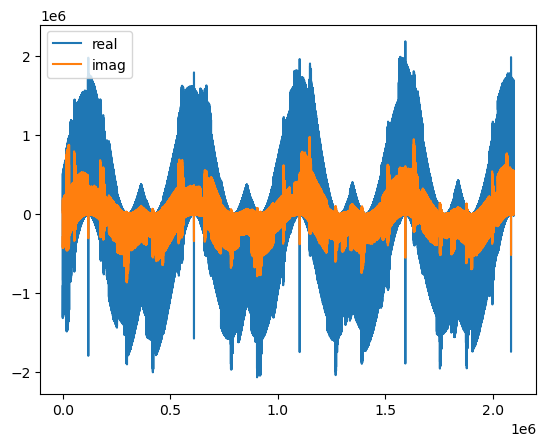

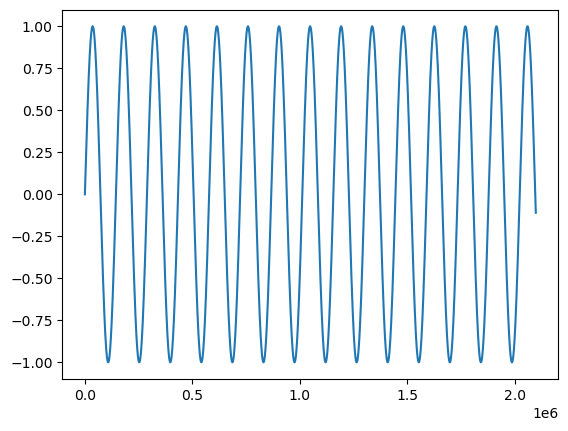

In [28]:
loopback_length = 7.62 # meters
loopback_length = 15.24 # meters

Δf_expected = loopback_length / k_1
print(f"Δf expected = {Δf_expected}")
print(f"Δf mixed = {Δf_expected * 2}")

T_rx = (1/sdr.sample_rate) * len(data_rx_0_h)
T_samp = np.linspace(0, T_rx, len(mixed_h))
resonant_expected = np.sin(T_samp * Δf_expected*2*2*np.pi)

plt.plot(mixed_h.real)
plt.plot(mixed_h.imag)
#plt.plot(resonant_expected)
plt.legend(["real", "imag", "expected"])
plt.show()

plt.plot(resonant_expected)
plt.show()
# plt.plot(mixed_decimated_h)
# plt.show()

In [29]:
T_rx = (1/sdr.sample_rate) * len(data_rx_0_h)
print(T_rx)

0.06826666666666667


The lowest beat frequency that can be extracted from the mixed signal, $f_{beat\ low} = \frac{1}{T_{buffer}}$ where $T_{buffer} = N_{buffer} * \frac{1}{T_s}$

For the fixed maximum $T_s$ of the Pluto SDR, $T_s = \frac{1}{30.72\ MHz} = 32.55\ ns$.

Assuming the radar needs to detect a range of 1m, then $\Delta f = \frac{R}{444.44} = \frac{1}{444.44} = 2.25 \cdot 10^{-3}\ Hz$

In order to detect energy in that frequency, the buffer size must be $T_{buffer} = \frac{1}{f_{beat \ low}} = \frac{1}{2.25 \cdot 10^{-3}\ Hz} = 444.44\ seconds$. The length of the buffer must be $N_{buffer} = \frac{T_{buffer}}{T_s} = \frac{444.44\ s}{32.55 \cdot 10^{-9} s} = 197529 \approx 200,000$

In [30]:
T_buffer = len(data_rx_1_h) * 1/sdr.sample_rate
print(f"T_buffer = {T_buffer * 1e3} ms")
print(f"Lowest frequnecy = {1/T_buffer} Hz")

T_buffer = 68.26666666666667 ms
Lowest frequnecy = 14.6484375 Hz


(0.0, 100.0)

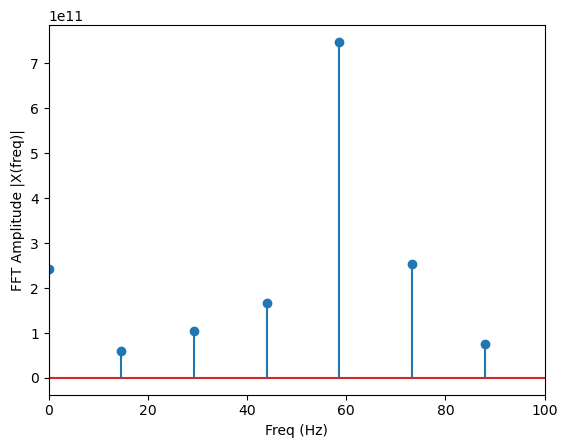

In [31]:
from scipy.fft import fft as sfft
sr = sdr.sample_rate
x = mixed_h

#X = sfft(mixed_decimated_h)
X = sfft(x)

N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

#plt.stem(freq, np.abs(X), 'b', \
#         markerfmt=" ", basefmt="-b")
plt.stem(freq, np.abs(X))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 100)

In [ ]:
sr = sdr.sample_rate
x = mixed_h

X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 200)

# plt.subplot(122)
# plt.plot(t, ifft(X), 'r')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.tight_layout()

In [ ]:
plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 1000)

In [ ]:
peaks = signal.find_peaks(np.abs(X))
print(peaks)
Δf = freq[peaks[0][0]]
print(f"Δf = {Δf}")
R = (3e8 * np.abs(Δf)) / (2*2*df_dt)
print(f"Range estimate = {R}")
#print(0.24*(Δf/2))
print(f"f0: {np.abs(X[0])/1e9}")
print(f"f1: {np.abs(X[1])/1e9}")
print(f"f2: {np.abs(X[2])/1e9}")

In [ ]:
# estimating fft density to interpolate distance
freq[peaks[0][0]]

In [ ]:
c0 = 3e8 # m/s
df = np.arange(0, 200, 10)

R = (c0 * df) / (2*dfdt)

plt.plot(df, R)
plt.xlabel("Δf (Hz)")
plt.ylabel("Range (m)")
plt.show()

In [ ]:
## Trying to come up with a digital mixing system

f0 = 3800 
f1 = 4000
f2 = f1-f0
t = np.arange(0, 100e-3, 1/sdr.sample_rate)
S0 = np.sin(f0*t)
S1 = np.sin(f1*t)
S2 = np.cos(f2*t)

plt.plot(t, S0)
plt.plot(t, S1)
plt.plot(t, S2)
plt.show()

mixed_mut = S0 * S1
plt.plot(t, mixed_mut)
plt.plot(t, S2)
plt.show()


In [ ]:
from numpy.fft import fft, ifft
sr = sdr.sample_rate
x = mixed_mut

X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 2000)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()

In [ ]:
peaks = signal.find_peaks(np.abs(X))
print(peaks)
freq[peaks[0][0]]

In [ ]:
def fast_spectrogram(x, fs):
    f, t, Sxx = signal.spectrogram(x, fs)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    ax = plt.gca()
    ax.set_ylim([0, 40000])
    plt.show()

In [ ]:
fast_spectrogram(data_rx_1.real, sdr.sample_rate)

In [ ]:
Rx_total = data_rx_0
ts = 1/sdr.sample_rate
NumSamples = len(Rx_total)
win = np.hamming(NumSamples)
y = Rx_total * win
sp = np.absolute(np.fft.fft(y))
sp = sp[1:-1]
sp = np.fft.fftshift(sp)
s_mag = np.abs(sp) / (np.sum(win)/2)    # Scale FFT by window and /2 since we are using half the FFT spectrum
s_dbfs = 20*np.log10(s_mag/(2**12))     # Pluto is a 12 bit ADC, so use that to convert to dBFS
xf = np.fft.fftfreq(NumSamples, ts)
xf = np.fft.fftshift(xf[1:-1])/1e6
plt.plot(xf, s_dbfs)
plt.xlabel("frequency [MHz]")
plt.ylabel("dBfs")
plt.draw()
plt.show()

In [ ]:
Rx_total = data_rx_1
ts = 1/sdr.sample_rate
NumSamples = len(Rx_total)
win = np.hamming(NumSamples)
y = Rx_total * win
sp = np.absolute(np.fft.fft(y))
sp = sp[1:-1]
sp = np.fft.fftshift(sp)
s_mag = np.abs(sp) / (np.sum(win)/2)    # Scale FFT by window and /2 since we are using half the FFT spectrum
s_dbfs = 20*np.log10(s_mag/(2**12))     # Pluto is a 12 bit ADC, so use that to convert to dBFS
xf = np.fft.fftfreq(NumSamples, ts)
xf = np.fft.fftshift(xf[1:-1])/1e6
plt.plot(xf, s_dbfs)
plt.xlabel("frequency [MHz]")
plt.ylabel("dBfs")
plt.draw()
plt.show()

In [ ]:
#plot.subplot(212)

plt.specgram( data_rx_0.real, Fs= 1/sdr.sample_rate )
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

plt.specgram( data_rx_1.real, Fs= 1/sdr.sample_rate )
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
chirp_duration = 16e-3
Ts = 1/sdr.sample_rate
BW = 2e6 # Hz
# trying to generate a chirp 
t_range = np.arange(0, chirp_duration, Ts)
FM_chirp = signal.chirp(t_range, 70, chirp_duration, 6000, method = 'linear')

FM_chirp = np.concatenate([FM_chirp, FM_chirp, FM_chirp, FM_chirp])

plt.plot(FM_chirp)
plt.show()

fs = 1/sdr.sample_rate
x = FM_chirp
f, t, Zxx = signal.stft(x, fs, nperseg=100)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()